In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [ ]:
from pathlib import Path
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as tf
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
dir_path = Path('/content/drive/MyDrive/aging/CACD_VS')
dir_path

PosixPath('/content/drive/MyDrive/aging/CACD_VS')

In [ ]:
image_list = list(dir_path.glob('*.jpg'))
len(image_list)

8004

In [ ]:
data = image_list[:2000]

In [ ]:
def plot_images(transform=None):
    sample = random.choice(data)
    img = Image.open(sample)
    if transform:
        transformed = transformer(img)
        plt.imshow(transformed.permute(1,2,0))
    else:
        img = np.array(img)
        plt.imshow(img)
    plt.axis("off")
    plt.show()

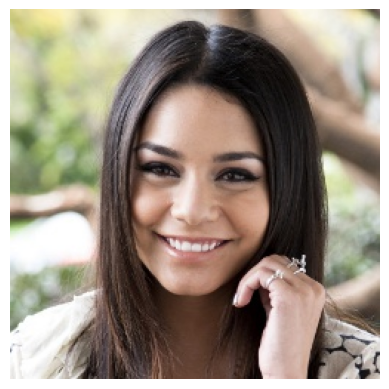

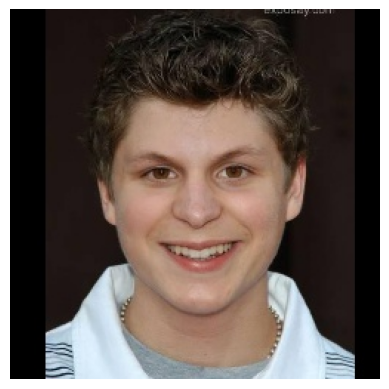

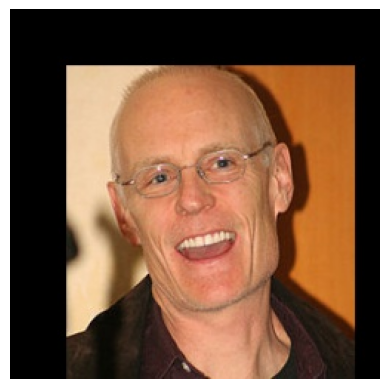

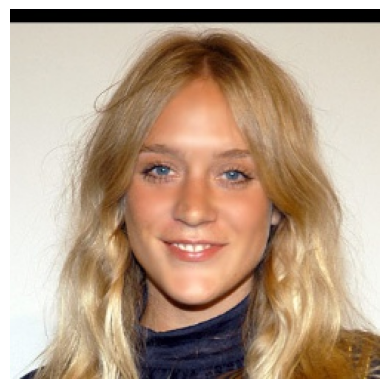

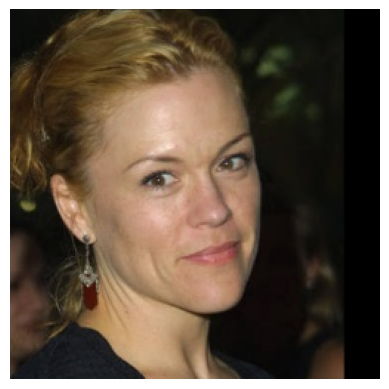

In [ ]:
for i in range(5):
    plot_images()

In [ ]:
transformer = tf.Compose([
    tf.Resize(size=(64,64)),
    tf.ToTensor()
])

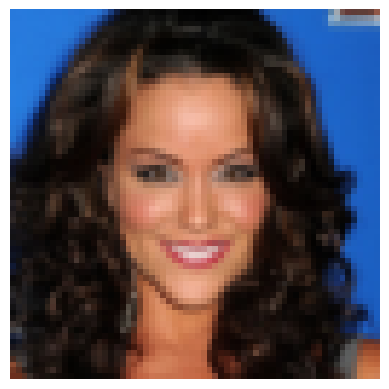

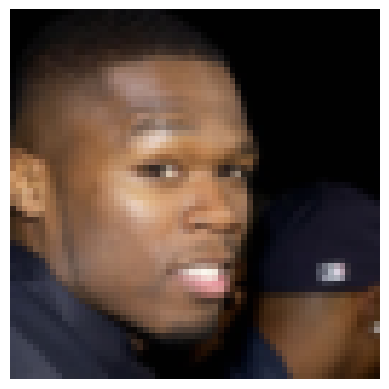

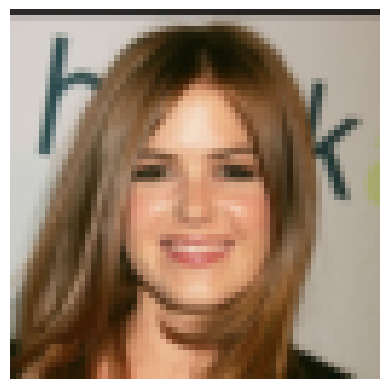

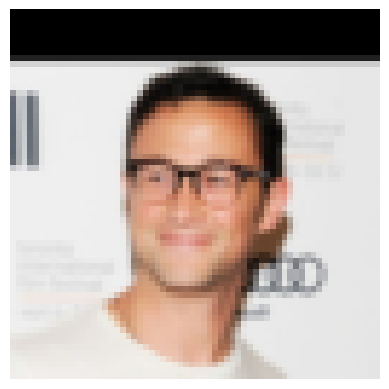

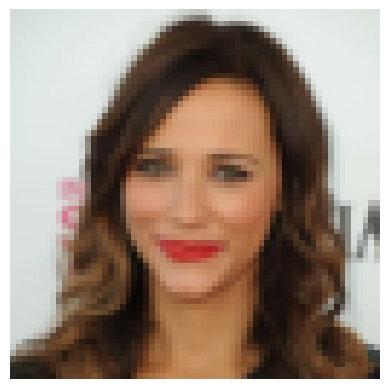

In [ ]:
for i in range(5):
    plot_images(transform=transformer)

In [ ]:
def plot_difference(transform=transformer):
    sample = random.choice(data)
    img = Image.open(sample)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[0].set_title("original")

    ax[1].imshow(transform(img).permute(1,2,0))
    ax[1].axis("off")
    ax[1].set_title("transformed")

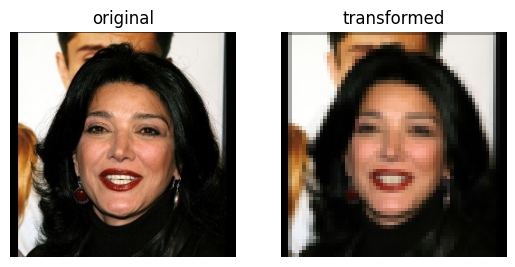

In [ ]:
plot_difference()

In [ ]:
train_data = data[:1600]
test_data = data[-400:]
len(train_data),len(test_data)

(1600, 400)

In [ ]:
class ImageGeneration(Dataset):
    def __init__(self,data,transformer):
        super().__init__()
        self.data = data
        self.transformer = transformer
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        img = Image.open(self.data[idx])
        return self.transformer(img)

In [ ]:
train_data = ImageGeneration(data=train_data,transformer=transformer)
test_data = ImageGeneration(data=test_data)
len(train_data),len(test_data)

TypeError: ignored

In [ ]:
bs = 1

train_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(test_data,batch_size=bs,shuffle=False)

# **First I am going to create a VAE architecture**


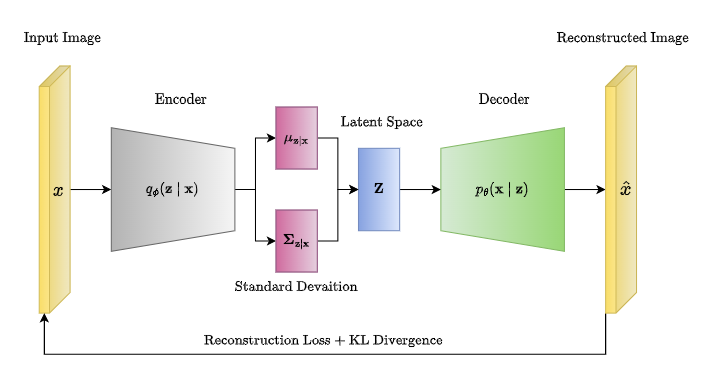


# Lets create encoder first


In [ ]:
class Encoder(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=3,
            stride=1,
        )

        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            stride=1
        )
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(115200,latent_dim)
        self.fc_logvar = nn.Linear(115200,latent_dim)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        x = x.view(x.size(0),-1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu,logvar

In [ ]:
z_dim = 200

In [ ]:
encoder = Encoder(latent_dim=z_dim).to(device)

In [ ]:
summary(encoder,input_size=(1,3,64,64))

In [ ]:
sample = torch.randn(1,3,64,64)

mu,logvar = encoder(sample.to(device))
print(f'mu: {mu} || len: {len(mu)}')

In [ ]:
class Decoder(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()

        self.fc = nn.Linear(latent_dim,32*60*60)

        self.deconv1 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=3,
            kernel_size=3,
            stride=1
        )
        self.relu = nn.ReLU()

    def forward(self,z):
        x = self.fc(z)
        x = x.view(x.size(0),32,60,60)
        x = self.relu(x)
        x = self.deconv1(x)
        x = self.relu(x)
        x = torch.sigmoid(self.deconv2(x))
        return x

In [ ]:
decoder = Decoder(latent_dim=z_dim).to(device)

In [ ]:
d_sample = torch.randn(1,z_dim)

output = decoder(d_sample.to(device))
output

In [ ]:
summary(model=decoder,input_size=[1,200])

In [ ]:
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim=latent_dim).to(device)
        self.decoder = Decoder(latent_dim=latent_dim).to(device)

    def reparameterize(self,mu,logvar):
        eps = torch.rand_like(logvar)
        z = mu + eps * torch.exp(0.5 * logvar)
        return z

    def forward(self,x):
        mu,logvar = self.encoder(x)
        z = self.reparameterize(mu,logvar)
        output = self.decoder(z)
        return output,mu,logvar

In [ ]:
vae = VAE(latent_dim=z_dim).to(device)

In [ ]:
summary(vae,input_size=(1,3,64,64))

In [ ]:
def loss_fn(output,X,mu,logvar):
    reconstruction_loss = nn.MSELoss(reduction='sum')(output,X)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (reconstruction_loss * 10000  + kl_divergence) / 100000

In [ ]:
loss_fn(output,sample,mu,logvar)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(),lr=0.0002)

In [ ]:
def train_step(
        model=vae,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    ):
    model.train()
    train_loss = 0
    for X in dataloader:
        X = X.to(device)
        optimizer.zero_grad(set_to_none=True)
        output,mu,logvar = model(X)
        loss = loss_fn(output,X,mu,logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(dataloader)
    return train_loss


In [ ]:
def test_step(
        model=vae,
        dataloader=test_loader,
        loss_fn=loss_fn,
        device=device

    ):
    model.eval()
    test_loss = 0
    for X in dataloader:
        X = X.to(device)
        output,mu,logvar = model(X)
        loss = loss_fn(output,X,mu,logvar)
        test_loss += loss
    test_loss /= len(dataloader)
    return test_loss


In [ ]:
epochs = 15

In [ ]:
for epoch in range(epochs):
    train_loss = train_step()
    test_loss = test_step()
    print(f"epoch: {epoch} | train loss: {train_loss} | test loss: {test_loss}")
    if test_loss < 8500:
        break

In [ ]:
vae.eval()
x = test_data[5]
x = x.unsqueeze(dim=0)
with torch.no_grad():
  z,a,b = vae(x.to(device))

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(x.squeeze().permute(1,2,0))
ax[1].imshow(z.squeeze().permute(1,2,0).cpu())


Lets create GAN Architecture


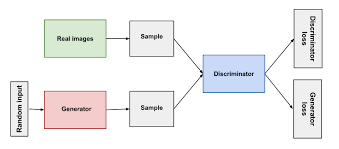

In [ ]:
train_data = data[:1600]
test_data = data[-400:]
len(train_data),len(test_data),data[1]

(1600, 400, PosixPath('/content/drive/MyDrive/aging/CACD_VS/3481_1.jpg'))

In [ ]:
gan_transformer = tf.Compose([
    tf.Resize(size=(62,62)),
    tf.ToTensor()
])

In [ ]:
train_data = ImageGeneration(data=train_data,transformer=gan_transformer)
test_data = ImageGeneration(data=test_data,transformer=gan_transformer)
len(train_data),len(test_data)

(1600, 400)

In [ ]:
bs = 1

train_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(test_data,batch_size=bs,shuffle=False)

# lets create discriminator first

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,3,1),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,32,3,1),
            nn.BatchNorm2d(num_features=32, momentum=0.9),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(107648,32)
        self.fc2 = nn.Linear(32,1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = self.fc2(x)
        return x


In [ ]:
discriminator = Discriminator().to(device)

In [ ]:
summary(discriminator,(1,3,62,62))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 60, 60]           --
│    └─Conv2d: 2-1                       [1, 64, 60, 60]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 60, 60]           128
│    └─LeakyReLU: 2-3                    [1, 64, 60, 60]           --
├─Sequential: 1-2                        [1, 32, 58, 58]           --
│    └─Conv2d: 2-4                       [1, 32, 58, 58]           18,464
│    └─BatchNorm2d: 2-5                  [1, 32, 58, 58]           64
│    └─LeakyReLU: 2-6                    [1, 32, 58, 58]           --
├─Linear: 1-3                            [1, 32]                   3,444,768
├─Linear: 1-4                            [1, 1]                    33
Total params: 3,465,249
Trainable params: 3,465,249
Non-trainable params: 0
Total mult-adds (M): 72.01
Input size (MB): 0.05
Forward/backwar

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,3,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,3,1),
             nn.ReLU(inplace=True)
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32,32,3),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,66,3,1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(66,3,5,1),
            nn.Tanh()
        )

    def forward(self,x):
        x1 = self.encoder(x)
        x2 = self.bottleneck(x1)
        x3 = self.decoder(x2)
        return x3

In [ ]:
generator = Generator().to(device)

In [ ]:
summary(generator,(1,3,62,62))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 62, 62]            --
├─Sequential: 1-1                        [1, 32, 58, 58]           --
│    └─Conv2d: 2-1                       [1, 64, 60, 60]           1,792
│    └─ReLU: 2-2                         [1, 64, 60, 60]           --
│    └─Conv2d: 2-3                       [1, 32, 58, 58]           18,464
│    └─ReLU: 2-4                         [1, 32, 58, 58]           --
├─Sequential: 1-2                        [1, 32, 56, 56]           --
│    └─Conv2d: 2-5                       [1, 32, 56, 56]           9,248
│    └─ReLU: 2-6                         [1, 32, 56, 56]           --
├─Sequential: 1-3                        [1, 3, 62, 62]            --
│    └─ConvTranspose2d: 2-7              [1, 66, 58, 58]           19,074
│    └─ReLU: 2-8                         [1, 66, 58, 58]           --
│    └─ConvTranspose2d: 2-9              [1, 3, 62, 62]            4,95

In [ ]:
disc_loss = nn.BCEWithLogitsLoss()
gen_loss = nn.MSELoss()

In [ ]:
disc_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.0002)
gen_optimizer = torch.optim.Adam(generator.parameters(),lr=0.0002)

In [ ]:
epochs = 15

In [ ]:
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    total_gen_loss = 0
    total_disc_loss = 0
    test_loss = 0
    for X in train_loader:
        X = X.to(device)
        disc_optimizer.zero_grad()
        fake_image = generator(X)
        fake_output = discriminator(fake_image.detach())
        #print(fake_output)
        fake_labels = torch.ones(X.size(0),1).to(device)
        #print(fake_labels)
        fake_loss = disc_loss(fake_labels,fake_output)
        #print(fake_loss)
        fake_loss.backward()
        disc_optimizer.step()
        total_disc_loss += fake_loss.item()

        gen_optimizer.zero_grad()
        fake_gen_image = generator(X)
        g_loss = gen_loss(fake_gen_image,X)
        g_loss.backward()
        gen_optimizer.step()
        total_gen_loss += g_loss.item()

    total_gen_loss /= len(train_loader)
    total_disc_loss /= len(test_loader)

    generator.eval()
    for X in test_loader:
        X = X.to(device)
        test_image = generator(X)
        loss = gen_loss(test_image,X)
        test_loss += loss
    test_loss /= len(test_loader)

    print(f'epoch: {epoch} <> genloss: {total_gen_loss} <> test_loss: {test_loss} <> discloss: {total_disc_loss}')





epoch: 0 <> genloss: 0.00783001591982611 <> test_loss: 0.002350166207179427 <> discloss: -898723.8657410588
epoch: 1 <> genloss: 0.0016809093973279231 <> test_loss: 0.0014384103706106544 <> discloss: -9161148.563125
epoch: 2 <> genloss: 0.0010929813491384265 <> test_loss: 0.0009973514825105667 <> discloss: -31050184.4428125
epoch: 3 <> genloss: 0.0008815959901130554 <> test_loss: 0.0007989766309037805 <> discloss: -69978951.9375
epoch: 4 <> genloss: 0.0007096795178358662 <> test_loss: 0.0006236256449483335 <> discloss: -128774826.365
epoch: 5 <> genloss: 0.0006151059744661325 <> test_loss: 0.000563219771720469 <> discloss: -210670255.48
epoch: 6 <> genloss: 0.0005315784272306701 <> test_loss: 0.000610034097917378 <> discloss: -318035416.27
epoch: 7 <> genloss: 0.0004888109839794196 <> test_loss: 0.00040661971434019506 <> discloss: -454385286.23
epoch: 8 <> genloss: 0.000449944403533209 <> test_loss: 0.0003993920108769089 <> discloss: -622388231.94
epoch: 9 <> genloss: 0.000433574845319

In [ ]:
generator.eval()
image = test_data[20]
with torch.no_grad():
  new_image = generator(image.to(device))

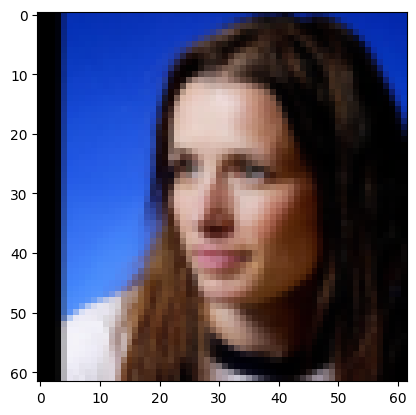

In [ ]:
plt.imshow(image.permute(1,2,0))

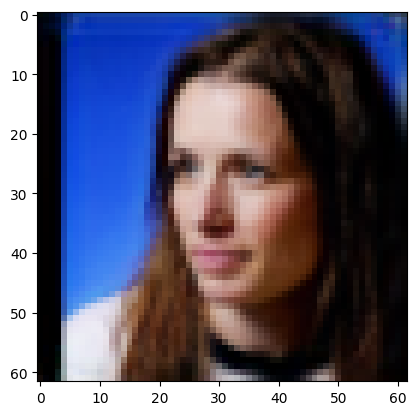

In [ ]:
plt.imshow(new_image.permute(1,2,0).cpu())